In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import PolyCollection, LineCollection
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)

from scipy.linalg import svdvals

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor
from solver import train
from utils import compose, svd

In [2]:
key = PRNGKey(0)

input_dim = 30
output_dim = 30
rank = 3
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, input_dim), rank=rank)

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_end_to_end)

In [3]:
n_outer_loops = 50
step_size = 1
result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    save_weights=True,
    n_inner_loops=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
V1 = compute_factor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=rank)
U1 = init_weights[0] @ V1 / init_scale

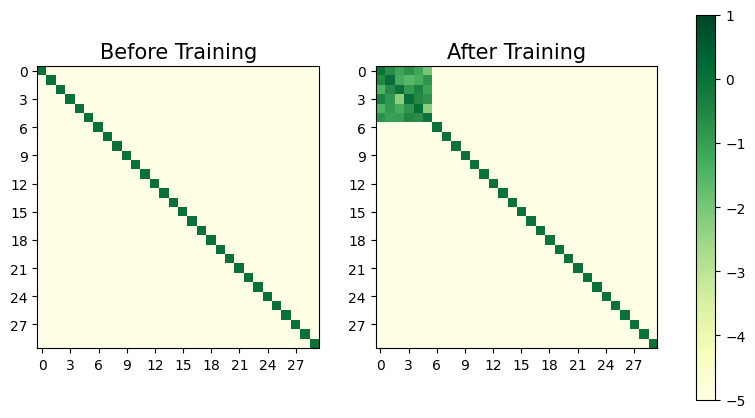

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes[0].imshow(jnp.log10(jnp.abs(U1.T @ init_weights[0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
axes[0].set_title('Before Training', fontsize=15)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

pcm = axes[1].imshow(jnp.log10(jnp.abs(U1.T @ result['final_weights'][0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
axes[1].set_title('After Training', fontsize=15)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(pcm, ax=axes.ravel().tolist())
# plt.savefig('figs/thm_main.png', dpi=300, bbox_inches='tight')

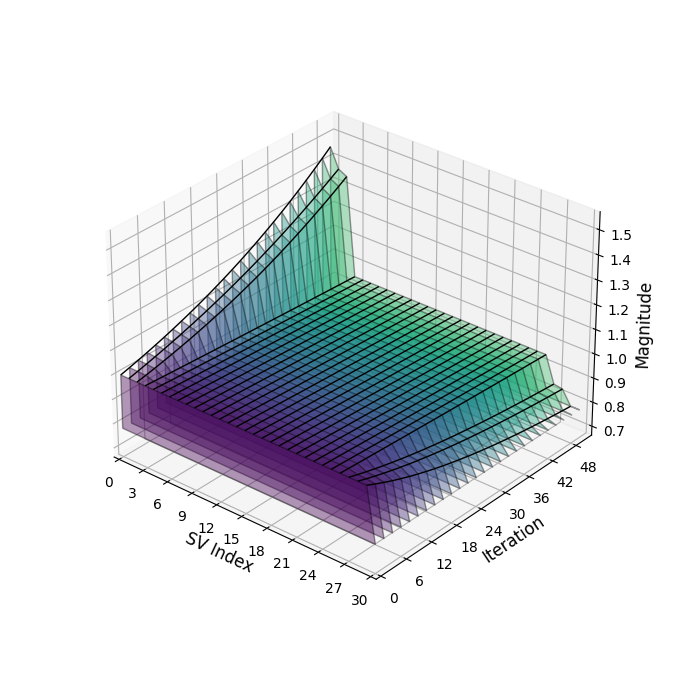

In [6]:
spec_step = 2

weights = result['weights']
sval_series = jnp.concatenate([svdvals(w[0]).reshape(1, -1) for w in weights], axis=0)

n_time_indices, n_sval_indices = sval_series.shape
time_indices = jnp.arange(n_time_indices)
sval_indices = jnp.arange(n_sval_indices)

spectrum_verts = []

for idx in time_indices[::spec_step]:
    spectrum_verts.append([
        (0, jnp.min(sval_series)), *zip(sval_indices, sval_series[idx, :]), (n_sval_indices, jnp.min(sval_series))
    ])

path_verts = []

for idx in sval_indices:
    path_verts.append([
        *zip(time_indices, sval_series[:, idx])
    ])

spectrum_poly = PolyCollection(spectrum_verts)
spectrum_poly.set_alpha(0.4)
spectrum_poly.set_facecolor(plt.colormaps['viridis'](jnp.linspace(0, 0.7, len(spectrum_verts))))
spectrum_poly.set_edgecolor('black')

path_line = LineCollection(path_verts)
path_line.set_linewidth(1)
path_line.set_edgecolor('black')

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.8)

ax.add_collection3d(spectrum_poly, zs=time_indices[::spec_step], zdir='y')
ax.add_collection3d(path_line, zs=sval_indices, zdir='x')

ax.set_xlabel('SV Index', fontsize=12)
ax.set_xlim(0, n_sval_indices)
ax.set_ylabel('Iteration', fontsize=12)
ax.set_ylim(0, n_time_indices)
ax.set_zlabel('Magnitude', fontsize=12)
ax.set_zlim(jnp.min(sval_series)-0.1, jnp.max(sval_series)+0.1)

elev = 30
azim = -50
roll = 0
ax.view_init(elev, azim, roll)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig('figs/thm_main.png', dpi=300, bbox_inches='tight')